# Predicting Housing Prices - Kaggle

In this notebook, I walk through the process of predicting housing prices in Kaggle's housing data competition. I prepare the data using various transformers. After processing the data, I use multiple algorithms and a bayesian optimizer to find the hyperparameters that minimze the error. Let's get started!

## Libraries and Initial Set-Up

In [10]:
# General libraries 
from math import ceil
import pandas as pd
import numpy as np
import random as ran

# Plots
import matplotlib.pyplot as plt

# Processing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import cross_val_score, train_test_split

# Optimizer
from bayes_opt import BayesianOptimization

# ML Models
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as RFR
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras import optimizers
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

Above, I import all the necessary packages. I import general libraries necessary to begin the script. I then import libraries to plot, process the data, score the models, and the necessary algorithms. 

Now, I'll do a little set up by pre-setting the seed, the number of crossfolds, importing the training data, finding missing values, and creating a comparison matrix. The comparision matrix will hold the name of the model, it's root mean squared error, and the best hyperparameters from the optimizer. The data frame allows me to compare model performance across each algorithm.

In [11]:
# Random draw of seed for random state #
#seed = int(ran.uniform(1, 9999))
''' Got 2095 '''
seed = 2095


# Set mnumber of cross folds #
cv = 5


# Import training data #
train = pd.read_csv('train.csv')


# Split into X and Y #
X = train.drop(['SalePrice', 'Id'], axis = 1)
y = pd.DataFrame(train['SalePrice'])


# Find missing values #
missing = X.isnull().sum().sort_values(ascending = False)


# Make matrix to compare models #
train_compare = pd.DataFrame(columns = ['Model', 'RMSE', 'hypers'])

## Initial Alteration of the Data Frame

The data frame has many missing values due to not having the feature that is being measured. For example, the frame has a variable call 'PoolQC' that measures the quality of the swiming pool. If the home does not have a pool, then it it labeled as missing. To avoid missing values in the frame, missing values were altered to fit the variable of interest. 

In [12]:
# Assign no pool (NP) to PoolQC #
X['PoolQC'].fillna('NP', inplace = True)


# Assign no feature (NF) to MiscFeature #
X['MiscFeature'].fillna('NF', inplace = True)


# Assign no ally (NAL) to Alley #
X['Alley'].fillna('NAL', inplace = True)


# Assign no fence (NF) to Fence #
X['Fence'].fillna('NF', inplace = True)


# Assign no fire place (NFP) to FireplaceQu #
X['FireplaceQu'].fillna('NFP', inplace = True)


# Assign no garage (NG) to GarageType #
X['GarageType'].fillna('NG', inplace = True)


# Fill garage variables with NG if no garage #
garage = ['GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
for x in garage:
    X[x].fillna('NG', inplace = True)
del x, garage


# Fix GarageYrBlt since it was mixed type #
X['GarageYrBlt'] = X['GarageYrBlt'].astype(str)


# Fill basement varaibles with no basement (NB) #
basement = ['BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']
for x in basement:
    X[x].fillna('NB', inplace = True)
del x, basement

## Plot Target Variable

After initial set-up, I'll plot the target variable to check for non-normality.

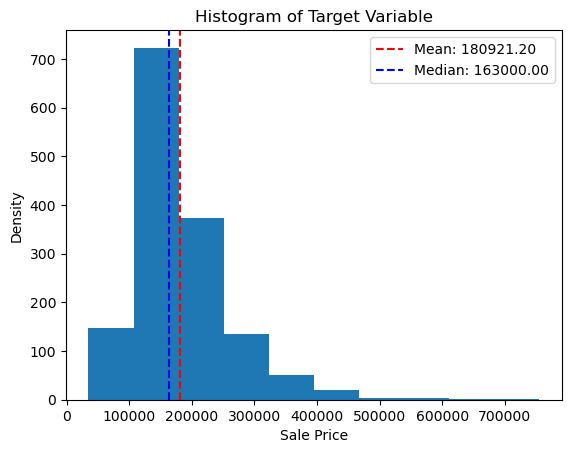

In [13]:
# Plot of Y #
plt.hist(y)
mean_value = y.mean()
median_value = y.median()
plt.axvline(mean_value.item(), color='red', linestyle='--', label='Mean')
plt.axvline(median_value.item(), color='blue', linestyle='--', label='Median')
plt.xlabel('Sale Price')
plt.ylabel('Density')
plt.title('Histogram of Target Variable')

# Add the text to the legend
mean_legend = plt.Line2D([], [], color='red', linestyle='--', label=f"Mean: {mean_value.item():.2f}")
median_legend = plt.Line2D([], [], color='blue', linestyle='--', label=f"Median: {median_value.item():.2f}")
plt.legend(handles=[mean_legend, median_legend])

plt.show()
del mean_value, median_value

The plot above demonstrates a right skew in the target due to the right tail. In addition, there is distance between the mean and median values of the variable. I'll transform the variable with a natural log function and re-plot the data to ensure normality. 

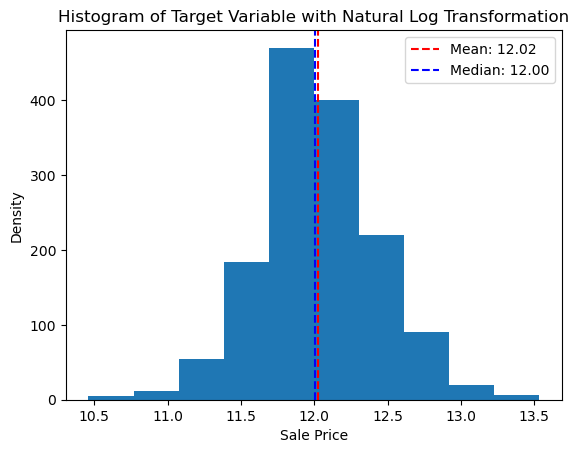

In [14]:
# Natural log the target variable #
y_log = np.log(y)

plt.hist(y_log)
mean_value = y_log.mean()
median_value = y_log.median()
plt.axvline(mean_value.item(), color='red', linestyle='--', label='Mean')
plt.axvline(median_value.item(), color='blue', linestyle='--', label='Median')
plt.xlabel('Sale Price')
plt.ylabel('Density')
plt.title('Histogram of Target Variable with Natural Log Transformation')

# Add the text to the legend
mean_legend = plt.Line2D([], [], color='red', linestyle='--', label=f"Mean: {mean_value.item():.2f}")
median_legend = plt.Line2D([], [], color='blue', linestyle='--', label=f"Median: {median_value.item():.2f}")
plt.legend(handles=[mean_legend, median_legend])

plt.show()
del mean_legend, mean_value, median_legend, median_value

After applying the transformation, the target variable is now noramlly distributed.

## Preprocessing

I'll now process the data to ensure is compatible for ML models. I'll split the data into training and validation data, which will be analyzed at the end. After, I encode my categorical variables and implement a KNN imputer. Last, I make a few variables into integer values. 

In [15]:
# Split into train and validation sets #
X_train, X_val, y_train, y_val = train_test_split(X, y_log, test_size = 0.25, 
                                                  random_state = seed)

# Mask of numerical features #
numeric_feats = X_train.select_dtypes(include = ['int64', 'float64']).columns


# Mask categorical features #
cat_feats = X_train.select_dtypes(include = ['object']).columns


# Encode object variables #
ord_enc = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value=np.nan)
X_train[cat_feats] = ord_enc.fit_transform(X_train[cat_feats])


# Transform X_val with encoder #
X_val[cat_feats] = ord_enc.transform(X_val[cat_feats])


# KNN Imputer #
knn_im = KNNImputer(n_neighbors = 10, weights = 'distance')
X_train_imp = pd.DataFrame(knn_im.fit_transform(X_train), columns = X_train.columns)


# KNN Imputer for X_val #
X_val_imp = pd.DataFrame(knn_im.transform(X_val), columns = X_val.columns)


# Variables need to be made integer #
X_train_imp[['Electrical', 'MasVnrType', 'GarageYrBlt', 'Exterior1st']] = X_train_imp[['Electrical', 'MasVnrType', 'GarageYrBlt', 'Exterior1st']]\
                                        .apply(lambda x: x.apply(ceil))
X_val_imp[['Electrical', 'MasVnrType', 'GarageYrBlt', 'Exterior1st']] = X_val_imp[['Electrical', 'MasVnrType', 'GarageYrBlt', 'Exterior1st']]\
                                        .apply(lambda x: x.apply(ceil))

## Feature Selection

The housing data includes numerous features, and many features are likely to be uncorrelated with the outcome. I limit the number of numeric features with a correlation threshold and the categorical features based on mutual information. 

In [16]:
# Correlation of numeric feats and target #
corr_val = pd.concat([X_train_imp[numeric_feats], y_train], axis =1).corr()['SalePrice']


# Mask of features with high correlation to target #
select_num = list(corr_val[(corr_val >= 0.50) | (corr_val <= -0.50)].index)
select_num.remove('SalePrice')


# Get mutual information of categorical features and outcome #
fs = SelectKBest(score_func = mutual_info_regression, k = 'all')
fs.fit(X_train_imp[cat_feats], np.ravel(y_train))


# Sort the scores and corresponding feature names in descending order
sorted_scores, sorted_features = zip(*sorted(zip(fs.scores_,
                                                 X_train_imp[cat_feats].columns),
                                             reverse=True))


# Select the top 20 features
top_20_cat_features = list(sorted_features[:20])


# Combine feature selection list #
selected_feats = select_num + top_20_cat_features


# DF of only selected features #
X_train_imp = X_train_imp[selected_feats]
X_val_imp = X_val_imp[selected_feats]
del corr_val, fs, sorted_features, sorted_scores

## Transformation

I now transform my data through categorical and numeric transformers based on the features in the limited data frame. I fit the transformer on the training data and then transform the training and validation data sets. 

In [17]:
########################
#### Transformation ####
########################

# Categorical transformer #
cat_trans = Pipeline(steps = [
    ('encode', OneHotEncoder(sparse_output = False))])


# Numeric tranformer #
num_trans = Pipeline(steps = [
    ('stand', StandardScaler())])


# Construct processor #
processor = ColumnTransformer(
    transformers = [
        ('num', num_trans, select_num),
        ('cat', cat_trans, top_20_cat_features)],
    remainder = 'passthrough')


# Apply processor to training data #
temp = processor.fit_transform(X_train_imp)


# Get categorical feature names #
enc_cat_features = list(processor.named_transformers_['cat']['encode']\
                        .get_feature_names_out())


# Concat label names #
labels = select_num + enc_cat_features 


# Make df of processed data #
X_train = pd.DataFrame(temp, columns = labels)
del temp


# Apply processor to validation data #
temp = processor.transform(X_val_imp)


# Get categorical feature names #
enc_cat_features = list(processor.named_transformers_['cat']['encode']\
                        .get_feature_names_out())


# Concat label names #
labels = select_num + enc_cat_features 


# Make df of processed data #
X_val = pd.DataFrame(temp, columns = labels)
del temp, y_log, X_val_imp, X_train_imp

# Start Estimating

After preparing the training and validation datasets, the next few sections outline my strategies for predicting the outcome of interest. I'll use seven different estimation strategies that include Ridge, Lasso, Elastic Net, Support Vector Machine, Random Forest, XGBoost, KNN, and a Neural Net in their regression forms. I use a bayesian optimizer to search for the model with the best predictive power. 

## Ridge

In [18]:
# Define objective for ridge #
def obj_ridge(alpha, fit_intercept, solver):
    
    """
    Objective function to minimize the error of the 
    ridge regression.    

    Parameters
    ----------
    alpha : L2 Regularization term.
        Regularizes the coefficients. Values stipulated
        in pbounds.
    fit_intercept : Boolean of fit intercept.
        Indicator of whether or not the model
        fits an intercept.
    solver : Solving method of ridge regression.
        Continuous variable for selecting the best
        solver for the regression.

    Returns
    -------
    error : Mean squared error.
        Cross validation returns root mean error that is later
        convereted into RMSE in the comparison frame.

    """
    
    # Fit intercept #
    fit_intercept = bool(round(fit_intercept))
    
    # Solver #
    if solver <= 1.0:
        solver = 'auto'
    elif solver <= 2.0:
        solver = 'svd'
    elif solver <= 3.0:
        solver = 'cholesky'
    elif solver <= 4.0:
        solver = 'lsqr'
    elif solver <= 5.0:
        solver = 'sparse_cg'
    elif solver <= 6.0:
        solver = 'sag'
    else:
        solver = 'saga'
    
    # Instantiate ridge model #
    model = Ridge(alpha=alpha, fit_intercept=fit_intercept, solver=solver,
                  max_iter = 20000, random_state=seed)
    
    # Cross validation and mean MSE #
    error = cross_val_score(model, X_train, y_train, cv=cv,
                            scoring='neg_mean_squared_error').mean()
    
    # Return error #
    return error


# Define search space #
pbounds = {
    'alpha': (0.00000001, 100),
    'fit_intercept': (0, 1),
    'solver': (0, 8),
}

# Set the optimizer #
optimizer = BayesianOptimization(
    f=obj_ridge, pbounds=pbounds, random_state=seed)

# Call maximizer #
optimizer.maximize(init_points=50, n_iter=450)


# Pull best info #
best_hypers = optimizer.max['params']
best_mse = optimizer.max['target']


# Replace solver with string #
if best_hypers['solver'] <= 1.0:
    best_hypers['solver']  = 'auto'
elif best_hypers['solver']  <= 2.0:
    best_hypers['solver']  = 'svd'
elif best_hypers['solver']  <= 3.0:
    best_hypers['solver']  = 'cholesky'
elif best_hypers['solver']  <= 4.0:
    best_hypers['solver']  = 'lsqr'
elif best_hypers['solver']  <= 5.0:
    best_hypers['solver']  = 'sparse_cg'
elif best_hypers['solver']  <= 6.0:
    best_hypers['solver']  = 'sag'
else:
    best_hypers['solver']  = 'saga'


# Fill comparison matrix #
train_compare = pd.concat([train_compare,
                           pd.DataFrame({'Model' : 'Ridge',
                            'RMSE': np.sqrt(best_mse * -1),
                            'hypers': [best_hypers]})], ignore_index = True)


# Sort by smallest RMSE #
train_compare = train_compare.sort_values('RMSE')

|   iter    |  target   |   alpha   | fit_in... |  solver   |
-------------------------------------------------------------


Exception: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported. Instead,please use the "set_gp_params" method to set
 the gp params, and pass an instance of bayes_opt.util.UtilityFunction
 using the acquisition_function argument


## Lasso

In [19]:
# Define objective function for lasso #
def obj_lasso(alpha, fit_intercept,
              selection): 
    
    """
    The objective of this function is to minimize the error
    of the lasso function. 
    
    Parameters
    ----------
    alpha : L1 Regularization term.
        Regularizes the coefficients. Values stipulated
        in pbounds.
    fit_intercept : Boolean of fit intercept.
        Indicator of whether or not the model
        fits an intercept.
    selection : Dictates coefficient updates.
        Continuous variable of using either cycle or
        random for coefficient update.

    Returns
    -------
    error : Mean squared error.
        Cross validation returns root mean error that is later
        convereted into RMSE in the comparison frame.
    """
    
    # Fit intercept #
    fit_intercept = bool(round(fit_intercept))
    
    
    # selection #
    if selection <= 0.5:
        selection = 'cyclic'
    else:
        selection = 'random'
    
    # Instantiate model #
    model = Lasso(alpha = alpha, fit_intercept = fit_intercept,
                  selection = selection,
                  random_state = seed, max_iter = 20000)
    
    # Cross validation and mean MSE #
    error = cross_val_score(model, X_train, y_train, cv=cv,
                            scoring='neg_mean_squared_error').mean()
    
    # Return error #
    return error


# Define search space #
pbounds = {
    'alpha': (0.0000001, 100),
    'fit_intercept': (0, 1),
    'selection': (0, 1)
}


# Set the optimizer #
optimizer = BayesianOptimization(
    f=obj_lasso, pbounds=pbounds, random_state=seed)

# Call maximizer #
optimizer.maximize(init_points = 50, n_iter = 450)


# Pull best info #
best_hypers = optimizer.max['params']
best_mse = optimizer.max['target']


# Replace selection with string #
if best_hypers['selection'] <= 0.5:
    best_hypers['selection'] = 'cyclic'
else:
    best_hypers['selection'] = 'random'


# Fill comparison matrix #
train_compare = pd.concat([train_compare,
                           pd.DataFrame({'Model' : 'Lasso',
                            'RMSE': np.sqrt(best_mse * -1),
                            'hypers': [best_hypers]})], ignore_index = True)

train_compare = train_compare.sort_values('RMSE')

|   iter    |  target   |   alpha   | fit_in... | selection |
-------------------------------------------------------------
| 1         | -144.9    | 54.96     | 0.04263   | 0.1776    |
| 2         | -144.9    | 26.97     | 0.2803    | 0.7405    |
| 3         | -0.1597   | 37.77     | 0.7732    | 0.2801    |
| 4         | -0.1597   | 78.0      | 0.7002    | 0.6631    |
| 5         | -0.1597   | 36.86     | 0.7854    | 0.1763    |
| 6         | -0.1597   | 37.67     | 0.5094    | 0.9447    |
| 7         | -0.1597   | 36.78     | 0.9452    | 0.4155    |
| 8         | -0.1597   | 38.87     | 0.5653    | 0.4373    |
| 9         | -28.32    | 4.091     | 0.3928    | 0.9653    |
| 10        | -0.1597   | 82.5      | 0.6042    | 0.1234    |
| 11        | -144.9    | 28.64     | 0.1985    | 0.1038    |
| 12        | -0.1597   | 10.73     | 0.7565    | 0.8618    |
| 13        | -144.9    | 72.14     | 0.01208   | 0.3532    |
| 14        | -0.1597   | 15.38     | 0.9466    | 0.3479    |
| 15    

| 81        | -0.1597   | 77.24     | 0.9987    | 0.7775    |


KeyboardInterrupt: 

## Elastic Net

In [ ]:
# Define objective function for Net #
def obj_net(alpha, l1_ratio, fit_intercept,
            selection):
    """
    The objective of this function is to minimize the error
    of the elastic net model. 

    Parameters
    ----------
    alpha : Float
        Constant the multiplies the penalty terms. 0 is equal to OLS.
    l1_ratio : Float
        Ratio of l1 or l2 regularization. 0 is l2. 1 is l1.
    fit_intercept : bool
        Option to fit an intercept.
    selection : String
        Specify how coefficients are updated across iterations. 

    Returns
    -------
    error : Float
        Cross validation returns root mean error that is later
        convereted into RMSE in the comparison frame.

    """
    
    # Vary fit intercept #
    fit_intercept = bool(round(fit_intercept))

    # Vary selection #
    if selection <= 0.5:
        selection = 'cyclic'
    else:
        selection = 'random'
        
    # Instantiate the model #
    model = ElasticNet(alpha = alpha, l1_ratio = l1_ratio,
                       fit_intercept =  fit_intercept,
                       selection = selection, random_state = seed,
                       max_iter = 20000)
    
    # Cross validation and mean MSE #
    error = cross_val_score(model, X_train, np.ravel(y_train), cv=cv,
                            scoring='neg_mean_squared_error').mean()
    
    # Return error #
    return error

# Define search space #
pbounds = {
    'alpha': (0.00001, 100),
    'l1_ratio': (0.001, 0.99),
    'fit_intercept': (0, 1),
    'selection': (0, 1)
}   


# Set the optimizer #
optimizer = BayesianOptimization(
    f=obj_net, pbounds=pbounds, random_state=seed)


# Call maximizer #
optimizer.maximize(init_points = 50, n_iter = 450)


# Pull best info #
best_hypers = optimizer.max['params']
best_mse = optimizer.max['target']


# Replace selection with string #
if best_hypers['selection'] <= 0.5:
    best_hypers['selection']  = 'cyclic'
else:
    best_hypers['selection']  = 'random'


# Fill comparison matrix #
train_compare = pd.concat([train_compare,
                           pd.DataFrame({'Model' : 'Elastic_Net',
                            'RMSE': np.sqrt(best_mse * -1),
                            'hypers': [best_hypers]})], ignore_index = True)

train_compare = train_compare.sort_values('RMSE') 

## Support Vector Machine

In [ ]:
# Define objective function for SVM #
def obj_SVR(kernel, degree,
            gamma, C, epsilon, 
            shrinking):
    """
    The objective of this function is to minimze the erro
    of the support vector regression.

    Parameters
    ----------
    kernel : Kernel used in solver.
        String inputs that are used in optimizer.
    degree : Degree of polyomial kernel.
        Only used in poly alogrithm.
    gamma : Kernel cofficient.
        Only used in rbf, poly, and sigmoid.
    C : L2 regularizer.
        More regularization at smaller values.
    epsilon : Epplison value in SVR model.
        Specifies penalty in training loss function.
    shrinking : Boolean value.
        Dictates if the model uses shrinking heuristic.

    Returns
    -------
    error : Mean squared error.
        Cross validation returns root mean error that is later
        convereted into RMSE in the comparison frame.

    """
    
    # Kernel #
    if kernel <= 1:
        kernel = 'linear'
    elif kernel <= 2:
        kernel = 'poly'
    elif kernel <= 3:
        kernel = 'rbf'
    else:
        kernel = 'sigmoid'
    
    # Gamma #
    if gamma <= 0.5:
        gamma = 'scale'
    else:
        gamma = 'auto'
        
    # Shrinking #
    shrinking = bool(round(shrinking))
        
    # Instantiate SVR #
    model = SVR(kernel =  kernel, degree = int(degree),
                gamma = gamma, C = C,
                epsilon = epsilon, shrinking = shrinking,
                max_iter = 50000)
    
    # Cross validation and mean MSE #
    error = cross_val_score(model, X_train, np.ravel(y_train), cv=cv,
                            scoring='neg_mean_squared_error').mean()
    
    # Return error #
    return error
    

# Define search space #
pbounds = {
    'kernel': (0, 4),
    'degree': (1, 10),
    'gamma': (0, 1),
    'C': (0.0001, 100),
    'epsilon': (0.0001, 100),
    'shrinking': (0, 1)
}


# Set the optimizer #
optimizer = BayesianOptimization(
    f=obj_SVR, pbounds=pbounds, random_state=seed)


# Call maximizer #
optimizer.maximize(init_points = 50, n_iter = 450)


# Pull best info #
best_hypers = optimizer.max['params']
best_mse = optimizer.max['target']


# Replace kernel with string #
if best_hypers['kernel'] <= 1:
    best_hypers['kernel'] = 'linear'
elif best_hypers['kernel'] <= 2:
    best_hypers['kernel'] = 'poly'
elif best_hypers['kernel'] <= 3:
    best_hypers['kernel'] = 'rbf'
else:
    best_hypers['kernel'] = 'sigmoid'
    

# Replace gamma with string #
if best_hypers['gamma'] <= 0.5:
    best_hypers['gamma'] = 'scale'
else:
    best_hypers['gamma'] = 'auto'


# Fill comparison matrix #
train_compare = pd.concat([train_compare,
                           pd.DataFrame({'Model' : 'SVR',
                            'RMSE': np.sqrt(best_mse * -1),
                            'hypers': [best_hypers]})], ignore_index = True)

train_compare = train_compare.sort_values('RMSE')

## Random Forest

In [ ]:
# Define objective function for random forest #
def obj_RF(n_estimators, criterion,
           min_samples_split, min_samples_leaf,
           max_features, bootstrap, min_impurity_decrease):
    """
    

    Parameters
    ----------
    n_estimators : Float
        Number of trees to estimate in the forest.
    criterion : String
        How the tree measures quality of the split.
    min_samples_split : Float
        Minimum number of samples required to split a node.
    min_samples_leaf : Float
        Minimum number of samples required to be a leaf.
    max_features : String
        Number of features to consider when splitting.
    bootstrap : Boolean
        Whether bootstraps are used when building trees.
    min_impurity_decrease : Float
        Node is split if it decreases the impurity.

    Returns
    -------
    error : Mean squared error.
        Cross validation returns root mean error that is later
        convereted into RMSE in the comparison frame.

    """
    
    # Criterion #
    if criterion <= 1.0:
        criterion = 'squared_error'
    elif criterion <= 2.0:
        criterion = 'absolute_error'
    elif criterion <= 3.0:
        criterion = 'friedman_mse'
    else:
        criterion = 'poisson'
        
    # Max features #
    if max_features <= 0.5:
        max_features = 'sqrt'
    else:
        max_features = 'log2'
        
    # Bootstrap #
    bootstrap = bool(round(bootstrap))
    
    # instantiate random forest moel #
    model = RFR(n_estimators = int(n_estimators), criterion = criterion,
                min_samples_split =  min_samples_split,
                min_samples_leaf = min_samples_leaf,
                max_features =  max_features, bootstrap =  bootstrap,
                min_impurity_decrease = min_impurity_decrease,
                n_jobs = -1, random_state = seed)
    
    # Cross validation and mean MSE #
    error = cross_val_score(model, X_train, np.ravel(y_train), cv=cv,
                            scoring='neg_mean_squared_error').mean()
    
    # Return error #
    return error


# Define search space #
pbounds = {
    'n_estimators': (1, 1000),
    'criterion': (0, 4),
    'min_samples_split': (0.01, .70),
    'min_samples_leaf': (0.01, .70),
    'max_features': (0, 1),
    'bootstrap': (0, 1),
    'min_impurity_decrease': (0.001, 0.4)
}


# Set the optimizer #
optimizer = BayesianOptimization(
    f=obj_RF, pbounds=pbounds, random_state=seed)


# Call maximizer #
optimizer.maximize(init_points = 50, n_iter = 450,)


# Pull best info #
best_hypers = optimizer.max['params']
best_mse = optimizer.max['target']


# Replace criterion with string #
if best_hypers['criterion'] <= 1.0:
    best_hypers['criterion'] = 'squared_error'
elif best_hypers['criterion'] <= 2.0:
    best_hypers['criterion'] = 'absolute_error'
elif best_hypers['criterion'] <= 3.0:
    best_hypers['criterion'] = 'friedman_mse'
else:
    best_hypers['criterion'] = 'poisson'
        

# Replace max features with string #
if best_hypers['max_features'] <= 0.5:
    best_hypers['max_features'] = 'sqrt'
else:
    best_hypers['max_features'] = 'log2'
        

# Fill comparison matrix #
train_compare = pd.concat([train_compare,
                           pd.DataFrame({'Model' : 'Random_Forest',
                            'RMSE': np.sqrt(best_mse * -1),
                            'hypers': [best_hypers]})], ignore_index = True)

train_compare = train_compare.sort_values('RMSE')

## XGBoost

In [ ]:
# Define objective function for XGBoost regression #
def obj_boost(n_estimators, eta, gamma, 
              max_depth, subsample, colsample_bytree,
              reg_lambda, alpha):
    """
    The objective of this function is to minimze the error
    of the XGBoosted random forest regression. 

    Parameters
    ----------
    n_estimators : Integer
        Number of trees to estimate.
    eta : Float
        Feature weight shrinkage that prevents overfitting.
    gamma : Float
        Min loss reduction needed to make partition on a leaf node.
    max_depth : Int
        Maximum depth of a tree. Deeper trees increase overfitting.
    subsample : Float
        Subsample of the dataset to use in tree.
    colsample_bytree : Float
        Subsample of columns to use in each tree.
    reg_lambda : Float
        L2 regularization on weights. Higher values make models more conservative.
    alpha : Float
        L1 regularization on weights. Higher values make models more conservative.

    Returns
    -------
    error : Float
        Cross validation returns root mean error that is later
        convereted into RMSE in the comparison frame.

    """
    
    # instantiate XGBoost #
    model = XGBRegressor(n_estimators = int(n_estimators), eta = eta,
                         gamma = gamma, max_depth = int(max_depth),
                         subsample = subsample, colsample_bytree = colsample_bytree,
                         reg_lambda = reg_lambda, alpha = alpha, 
                         seed = seed, n_jobs = 1)
    
    # Cross validation and mean MSE #
    error = cross_val_score(model, X_train, np.ravel(y_train), cv=cv,
                            scoring='neg_mean_squared_error').mean()
    
    # Return error #
    return error

    
# Define the search space #
pbounds = {
    'n_estimators': (1, 2000),
    'eta': (0, 1),
    'gamma': (0, 5),
    'max_depth': (2, 7),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.2, 0.9),
    'reg_lambda': (0.05, 10),
    'alpha': (0.05, 10)
}


# Set the optimizer #
optimizer = BayesianOptimization(
    f=obj_boost, pbounds=pbounds, random_state=seed)


# Call maximizer #
optimizer.maximize(init_points = 50, n_iter = 450)


# Pull best info #
best_hypers = optimizer.max['params']
best_mse = optimizer.max['target']


# Fill comparison matrix #
train_compare = pd.concat([train_compare,
                           pd.DataFrame({'Model' : 'XGBoost_Reg',
                            'RMSE': np.sqrt(best_mse * -1),
                            'hypers': [best_hypers]})], ignore_index = True)

train_compare = train_compare.sort_values('RMSE')

## KNN

In [ ]:
# Define objective function for K-Nearest Neighbors #
def obj_knn(n_neighbors, weights, algorithm,
            leaf_size, p):
    """
    This objective function minimzes the error for k-nearest
    neighbors regression.

    Parameters
    ----------
    n_neighbors : int
        Number of neighbors to use.
    weights : String
        Weight function used in prediction.
    algorithm : String
        Process used to compute the nearest neighbors.
    leaf_size : int
        Leaf size passed to specific algorithms.
    p : int
        Power parameter for Minkowski metric.

    Returns
    -------
    error : Float
        Cross validation returns root mean error that is later
        convereted into RMSE in the comparison frame.

    """
    
    # Variation on weights #
    if weights <= 0.5:
        weights = 'uniform'
    else:
        weights = 'distance'
    
    # Variation on algorithm #
    if algorithm <= 1.0:
        algorithm = 'auto'
    elif algorithm <= 2.0:
        algorithm = 'ball_tree'
    elif algorithm <= 3.0:
        algorithm = 'kd_tree'
    else:
        algorithm = 'brute'
    
    # Variation on p #
    if p <= 1.0:
        p = 1
    elif p <= 1.0 and algorithm != 'brute':
        p = 1
    else:
        p = 2
    
    # Instantiate model #
    model = KNeighborsRegressor(n_neighbors =  int(n_neighbors), weights = weights,
                                algorithm = algorithm, leaf_size = int(leaf_size), p = p)
    
    # Cross validation and mean MSE #
    error = cross_val_score(model, X_train, np.ravel(y_train), cv=cv,
                            scoring='neg_mean_squared_error').mean()
    
    # Return error #
    return error
    

# Define search space #
pbounds = {
    'n_neighbors': (2, 10),
    'weights': (0, 1),
    'algorithm': (0, 4),
    'leaf_size': (2, 50),
    'p': (0.001, 2)
}


# Set the optimizer #
optimizer = BayesianOptimization(
    f=obj_knn, pbounds=pbounds, random_state=seed)


# Call maximizer #
optimizer.maximize(init_points = 50, n_iter = 450)


# Pull best info #
best_hypers = optimizer.max['params']
best_mse = optimizer.max['target']


# Replace weights with string #
if best_hypers['weights'] <= 0.5:
    best_hypers['weights'] = 'uniform'
else:
    best_hypers['weights'] = 'distance'
    
    
# Replace algorithm with string #
if best_hypers['algorithm'] <= 1.0:
    best_hypers['algorithm'] = 'auto'
elif best_hypers['algorithm'] <= 2.0:
    best_hypers['algorithm'] = 'ball_tree'
elif best_hypers['algorithm'] <= 3.0:
    best_hypers['algorithm'] = 'kd_tree'
else:
    best_hypers['algorithm'] = 'brute'
    

# Replace p #
if best_hypers['p'] <= 1.0:
    best_hypers['p'] = 1
elif best_hypers['p'] <= 1.0 and best_hypers['algorithm'] != 'brute':
    best_hypers['p'] = 1
else:
    best_hypers['p'] = 2
    


# Fill comparison matrix #
train_compare = pd.concat([train_compare,
                           pd.DataFrame({'Model' : 'KNN_Reg',
                            'RMSE': np.sqrt(best_mse * -1),
                            'hypers': [best_hypers]})], ignore_index = True)

train_compare = train_compare.sort_values('RMSE')

## Neural Network

In [ ]:
# Define objective function for network #
def obj_net(batch_size, epochs, activation, num_nodes,
            num_hidden_layers, learning_rate, rate, optimizer):
    """
    The objective of this function is to minimize the error of the
    neural network

    Parameters
    ----------
    batch_size : Int
        The number of cases to include in each batch.
    epochs : Int
        Number of runs through the data when updating weights.
    activation : String
        Type of activation function for the layer.
    num_nodes : Int
        Number of nodes to include in the hidden layer.
    num_hidden_layers : Int
        Number of hideen layers in the model.
    learning_rate : Float
        How much to change the model with each model update.
    rate : Float
        Dropout rate for each hidden layer to prevent overfitting.
    optimizer : String
        Optimizer to use for the model.

    Returns
    -------
    error : Float
        Cross validation returns root mean error that is later
        convereted into RMSE in the comparison frame.

    """
    
    # Set Optimizer #
    if optimizer <= 0.33:
        optimizer = optimizers.Adam(learning_rate = learning_rate)
    
    elif optimizer <= 0.66:
        optimizer = optimizers.Adagrad(learning_rate = learning_rate)
    
    else:
        optimizer = optimizers.RMSprop(learning_rate = learning_rate)
        
    # Set activation function #
    if activation <= 0.33:
        activation = 'relu'
        
    elif activation <= 0.66:
       activation = 'sigmoid'
       
    else:
       activation = 'tanh'
       
    # Instantiate model
    model = Sequential()
    
    # Set input layer #
    model.add(Dense(int(num_nodes), activation = activation, 
                    input_shape = (X_train.shape[1],)))
    
    # Set hidden layer with batch normalizer #
    for _ in range(int(num_hidden_layers)):
        model.add(Dense(int(num_nodes), activation = activation))
        model.add(BatchNormalization())
        model.add(Dropout(rate = rate, seed = seed))
    
    # Add output layer #
    model.add(Dense(1))
    
    # Set compiler #
    model.compile(optimizer = optimizer,
                  loss = 'mean_squared_error')
    
    # Set early stopping #
    early_stopping = EarlyStopping(monitor='val_loss', 
                                   patience=15, 
                                   restore_best_weights=True)
    
    # Create model #
    reg = KerasRegressor(model = lambda : model,
                         batch_size = int(batch_size),
                         epochs = int(epochs),
                         validation_split = 0.2,
                         callbacks = [early_stopping],
                         random_state = seed)

    # Cross validation and mean MSE #
    error = cross_val_score(reg, X_train, np.ravel(y_train), cv=cv,
                        scoring='neg_mean_squared_error').mean()

    # Return error #
    return error

# Define search space #
pbounds = {
    'batch_size': (50, 1460),
    'epochs': (5, 500),
    'learning_rate': (0.001, 0.15),
    'num_nodes': (5, 80),
    'num_hidden_layers': (2, 20),
    'activation': (0, 1),
    'rate': (0.0, 0.9),
    'optimizer': (0, 1)
}


# Set the optimizer #
optimizer = BayesianOptimization(f=obj_net, pbounds=pbounds,
                                 random_state=seed)


# Call the maximizer #
optimizer.maximize(init_points=50, n_iter=450)


# Pull best info #
best_hypers = optimizer.max['params']
best_mse = optimizer.max['target']


# Replace optimizer and learning rate #
if best_hypers['optimizer'] <= 0.33:
    best_hypers['optimizer'] = optimizers.Adam(learning_rate = best_hypers['learning_rate'])
    
elif best_hypers['optimizer'] <= 0.66:
    best_hypers['optimizer'] = optimizers.Adagrad(learning_rate = best_hypers['learning_rate'])
    
else:
    best_hypers['optimizer'] = optimizers.RMSprop(learning_rate = best_hypers['learning_rate'])
    
    
# Replace activation with string #
if best_hypers['activation'] <= 0.33:
    best_hypers['activation'] = 'relu'
        
elif best_hypers['activation'] <= 0.66:
      best_hypers['activation'] = 'sigmoid'
       
else:
     best_hypers['activation'] = 'tanh'


# Fill comparison matrix #
train_compare = pd.concat([train_compare,
                           pd.DataFrame({'Model' : 'Neural_Net',
                            'RMSE': np.sqrt(best_mse * -1),
                            'hypers': [best_hypers]})], ignore_index = True)

train_compare = train_compare.sort_values('RMSE')